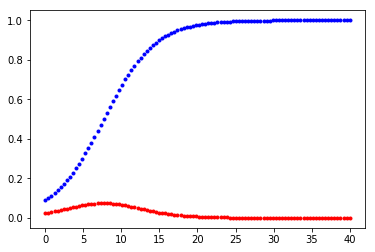

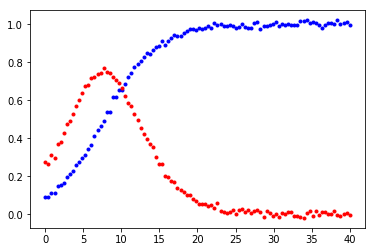

In [1094]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from PDEFind_class import PDE_Findclass
import copy
import glob
import os
from PDE_FIND2 import *
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import KFold

t = np.linspace(0,40,100)
dt = t[1] - t[0]

k = 0.3

u = np.exp(k*t)/(10 + np.exp(k*t))
for i in range(len(u)):
    u[i] = u[i] #+ random.normal(loc=0, scale=0.005)
ut = np.zeros(u.shape)

#compute derivative
for i in np.arange(1,len(u)-1):
    ut[i] = (u[i+1] - u[i-1])/(2*dt)# + random.normal(loc=0, scale=0.01)
ut[0] = (u[1] - u[0])/dt
ut[-1] = (u[-1] - u[-2])/dt

plt.figure()
plt.plot(t,u,'b.')
plt.plot(t,ut,'r.')
plt.show()

variables = [t[:,np.newaxis],u[:,np.newaxis],ut[:,np.newaxis]]
variable_names = ['t','u','u_t']

data = {}
data['variables'] = variables
data['variable_names'] = variable_names

mat = data

#time vector       
t = mat['variables'][0]    
#U values
U = mat['variables'][1]

for i in range(len(U)):
    U[i] = U[i] + random.normal(loc=0, scale=0.01)
#Ut vector
Ut = mat['variables'][2]*10

for i in range(len(Ut)):
    Ut[i] = Ut[i] + random.normal(loc=0, scale=0.01)

    
plt.figure()
plt.plot(t,U,'b.')
plt.plot(t,Ut,'r.')
plt.show()
    
#Theta = np.hstack((np.ones(U.shape),U,U**2,U**3, U**4, U**5, U**6, U**7, U**(-1), U**(-2)))

Theta = np.hstack((np.ones(U.shape),U,U**2,U**3, U**4, U**5, U**6, U**7, U**8 ))

Theta = preprocessing.scale(Theta)
Theta[:,0] = 1

#description = ['u^0','u^1','u^2','u^3','u^4','u^5','u^6','u^7', 'u^-1', 'u^-2']

description = ['u^0','u^1','u^2','u^3','u^4','u^5','u^6','u^7','u^8']

dim = len(description)

In [1118]:
print "Full regression predicts the ODE model:"
print linear_model.LinearRegression().fit(Theta,Ut).coef_

#print ""
#print "Bootstrap Model Selection - regression predicts the ODE model:"
#bootSelect(Theta, Ut, dim = dim, description = description, reg = linear_model.LassoCV(alphas = np.linspace(0.001, 0.01, 100), cv = 10))

#print ""
#print "Ridge + Boot - regression predicts the ODE model:"
#Ridge_Boot(Theta, Ut, dim = dim, description = description)

#print ""
#print "Ridge + CV - regression predicts the ODE model:"
#1 loop, best of 3: 1.9 s per loop %timeit
Ridge_CV(Theta, Ut, dim = dim, description = description, InCr = "BIC")

print ""
print "Lasso + CV - regression predicts the ODE model:"
# 10 loops, best of 3: 126 ms per loop %timeit 
Ridge_CV(Theta, Ut, dim = dim, model = linear_model.LassoCV, description = description, InCr = "BIC")

#print ""
#print "ElasticNet + CV - regression predicts the ODE model:"
#Ridge_CV(Theta, Ut, dim = dim, model = linear_model.ElasticNetCV, description = description, InCr = "BIC")


print ""
print "Relaxed Lasso - regression predicts the ODE model:"
#1 loop, best of 3: 286 ms per loop %timeit
relaxedLasso(Theta, Ut, dim = dim, description = description, InCr = "BIC")

Full regression predicts the ODE model:
[[    0.            -2.15236723    34.42796031  -190.11966986
    573.528336   -1028.45977084  1084.26428687  -619.5197735
    147.82380608]]
Best BIC = -358.4873194738241
Ut = 
-0.24785038206892995 u^7

Lasso + CV - regression predicts the ODE model:
Best BIC = -368.7297706459778
Ut = 
-1.0605981011359005 u^2 + 
0.8477447467768039 u^1

Relaxed Lasso - regression predicts the ODE model:
Best BIC = -350.63778066568364
Ut = 
-1.0605981011359005 u^2 + 
0.8477447467768039 u^1


(array([  7.21419828, -11.39052095,  14.86568109, -16.12077332,
          5.24183709,  -0.01713829]), -350.63778066568364)

In [520]:
def Ridge_Boot(Theta, Ut, dim, description):
    ##Cross Validation
    from sklearn.model_selection import KFold
    from sklearn.linear_model import RidgeCV

    best_lambda_tol = None
    best_d_tol = None
    best_meanOfResiduals = 100000000
    best_pde = None
    
    #clf = RidgeCV(alphas=np.linspace(0.000001, 0.00001, 50)).fit(Theta, Ut)
    return bootSelect(Theta, Ut, dim, description, reg = RidgeCV(alphas=np.linspace(0.001, 0.001, 50)))

In [1079]:
def bootSelect(Theta, Ut, dim, description, Bag = 100, reg = linear_model.LinearRegression()):
    from sklearn import linear_model
    from sklearn.utils import resample
    boot_reg_coef = []
    for i in range(Bag):
        X, y = resample(Theta, Ut, replace=True)
        reg.fit(X, y)
        boot_reg_coef.append(reg.coef_)
    boot_reg_coef = np.array(boot_reg_coef)
    #print(boot_reg_coef)
    
    for i in range(dim):
        coef = boot_reg_coef[:, i]
        coef = np.sort(coef)
        print description[i] + ":[" + str(coef[int(0.10 * Bag)]) + " , " + str(coef[int(0.90 * Bag)]) + "]"
    
    reg_coef = []
    k = len(boot_reg_coef)
    for i in range(dim):
        coef = boot_reg_coef[:, i]
        coef = np.sort(coef)
        if coef[int(0.10 * Bag)] < 0 and coef[int(0.90 * Bag)] > 0:
            reg_coef.append(0)
        else:
            reg_coef.append(np.mean(coef))
    return bestSubsetSelection(Theta, Ut, reg_coef, description)

In [1111]:
def Ridge_CV(Theta, Ut, dim, description, model = linear_model.RidgeCV, InCr = "AIC"):

    best_lambda_tol = None
    best_d_tol = None
    best_sumOfResiduals = 100000000
    best_pde = None
    
    RidgeResult = model(alphas = np.linspace(0.00001, 0.01, 100), cv = 10).fit(Theta, Ut)
    best_lambda_tol = RidgeResult.alpha_
    if model == linear_model.RidgeCV:
        RidgeResult.coef_ = RidgeResult.coef_[0]
    sortedCoef = np.sort(abs(RidgeResult.coef_))
    ## mini = index of the sortedCoef
    mini = 0
    #Swapping unnecessary Betas into zero
    # Trying rule of thumb as sortedCoef[dim - 1]/3
    for d_tol in np.linspace(0, sortedCoef[dim - 1]/2, 50):
        if sortedCoef[mini] >= d_tol:
            # Skip
            continue
        for j in range(dim):
            curCoef = abs(RidgeResult.coef_[j])
            if curCoef < d_tol:
                # update mini
                while sortedCoef[mini] <= curCoef:
                    mini = mini + 1
                RidgeResult.coef_[j] = 0
        
        kf = KFold(n_splits=10, shuffle=True)
        residualList = []
        for train, test in kf.split(Ut):
            sumOfResiduals = np.linalg.norm(Ut[test] - Theta[test].dot(np.transpose(RidgeResult.coef_)))
            residualList.append(sumOfResiduals)
        sumOfResiduals = np.sum(residualList)
        if best_sumOfResiduals > sumOfResiduals:
            best_d_tol = d_tol
            best_pde = RidgeResult.coef_
            best_sumOfResiduals = sumOfResiduals
    #print "best_lambda_tol = " + str(best_lambda_tol)
    #print "best_d_tol = " + str(best_d_tol)
    #print "best_pde = " + str(RidgeResult.coef_)
    #print "best_sumOfResiduals = " + str(best_sumOfResiduals)
    return bestSubsetSelection(Theta, Ut, best_pde, description, InCr = InCr)

In [1087]:
def bestSubsetSelection(Theta, Ut, best_pde, description, InCr = "AIC"):
    Theta = np.transpose(Theta)
    best_IC = 100000000
    best_reg = None
    best_subset = []
    #sublib = [non-zero indices]
    sublib = []
    for i in range(len(best_pde)):
        if best_pde[i] != 0:
            sublib.append(i)
    
    Theta_new = copy.deepcopy(Theta[sublib])
    
    # Best Subset Selection ** expensive
    sublib_size = len(sublib)
    description = np.array(description)

    for i in range(1, 2**sublib_size):
        subset = []
        j = i
        cur = sublib_size - 1
        while j:
            if j & 1:
                subset.append(cur)
            cur = cur - 1
            j = j >> 1
        
        reg, IC = getIC(np.transpose(Theta_new[subset]), Ut, len(subset), InCr = InCr)
        if IC < best_IC:
            best_IC = IC
            best_reg = reg
            best_subset = subset
        
    print "Best " + InCr + " = " + str(IC)
    print "Ut = "
    for i in range(len(best_reg) - 1):
        print str(best_reg[i]) + " " + str(description[sublib][best_subset][i]) + " + "
    print str(best_reg[len(best_reg) - 1]) + " " + str(description[sublib][best_subset][len(best_reg) - 1])
    return reg, IC

In [1086]:
def subsetData(Theta, best_pde, description):
    Theta = np.transpose(Theta)
    best_reg = None
    best_subset = []
    #sublib = [non-zero indices]
    sublib = []
    for i in range(len(best_pde)):
        if best_pde[i] == 0:
            sublib.append(i)
    Theta_new = copy.deepcopy(Theta)
    Theta_new[sublib] = 0
    description = np.array(description)
    return np.transpose(Theta_new), description[sublib]

In [1085]:
def getIC(Theta, Ut, p, InCr = "AIC"):
    from sklearn import linear_model
    reg = linear_model.LinearRegression()
    reg.fit(Theta, Ut)
    n = len(Ut)
    sumOfResiduals = np.linalg.norm(Ut - Theta.dot(np.transpose(reg.coef_)))
    ICDict = {"AIC": n*np.log(sumOfResiduals)+2*p,
              "BIC": n*np.log(sumOfResiduals/n)+p*np.log(n)}
    return reg.coef_[0], ICDict[InCr]
# "AIC": n*np.log(sumOfResiduals)+2*p

In [1113]:
def relaxedLasso(Theta, Ut, dim, description, InCr = "AIC"):
    best_coef = linear_model.LassoCV(alphas = np.linspace(0.0001, 0.01, 100), cv = 10).fit(Theta, Ut).coef_
    Theta_new, description_new = subsetData(Theta, best_coef, description)
    second_coef = linear_model.LassoCV(alphas = np.linspace(0.0001, 0.001, 100), cv = 10).fit(Theta_new, Ut).coef_
    return bestSubsetSelection(Theta, Ut, second_coef, description, InCr = InCr)